In [9]:
import os
import glob

def find_files(directory, re):
    '''Given a directory and a regular expression, find all files that match in that directory.'''
    # Test the directory exists
    if not os.path.isdir(directory):
        os.sys.exit('Cannot find directory {}. Exiting...'.format(directory))

    # Find files
    files = sorted(glob.glob(os.path.join(directory, re)))

    return files

In [10]:
# input_directory = os.path.join('.', 'Data')
# data_regular_expression = 'package4_T*CH1.CSV' # pull our package 4 data
# # Read files
# files = find_files(input_directory, data_regular_expression)
# print('Found {} files'.format(len(files)))

# # Read data
# print('Reading in files...')
# data = read_data(files)

In [11]:
%pip install pydicom

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Get DICOM file
import pydicom

filename = 'Images/Calc-Test_P_00127_RIGHT_CC/08-29-2017-DDSM-NA-48220/1.000000-full mammogram images-81950/1-1.dcm'
RefDs = pydicom.read_file(filename)

# Let's print all the Metadata here
print(RefDs)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.380446188711644394103959098213894985626
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.380446188711644394103959098213894985626
(0008, 0020) Study Date                          DA: ''
(0008, 0023) Content Date     

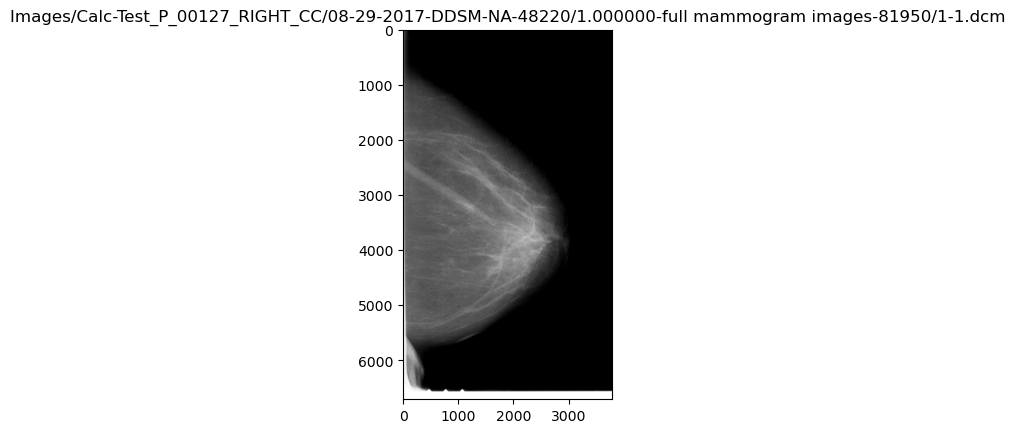

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# To obtain the dimensions of the array to store the image we will use the metadata
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))

# Then initialize in zeros an array
image = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Finally we had already read the file and we have the image information in the pixel_array (final field)
image[:,:]=RefDs.pixel_array

plt.title(filename)
plt.imshow(image, plt.cm.gray)

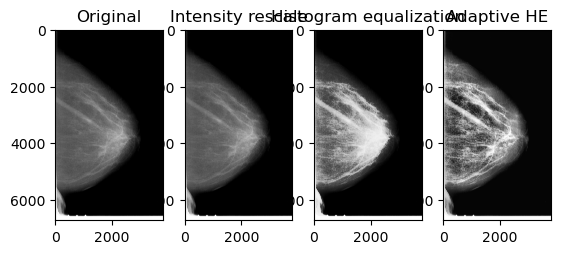

In [39]:
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
# image processing to prepare for edge detection
from skimage import exposure

# Contrast stretching
p2, p98 = np.percentile(image, (2, 98))
image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

# Equalization
image_eq = exposure.equalize_hist(image)

# Adaptive Equalization
image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)

plt.subplots(1, 4)

plt.subplot(141)
plt.title("Original")
plt.imshow(image, plt.cm.gray)

plt.subplot(142)
plt.title("Intensity rescale")
plt.imshow(image_rescale, plt.cm.gray)

plt.subplot(143)
plt.title("Histogram equalization")
plt.imshow(image_eq, plt.cm.gray)

plt.subplot(144)
plt.title("Adaptive HE")
plt.imshow(image_adapteq, plt.cm.gray)
plt.show()

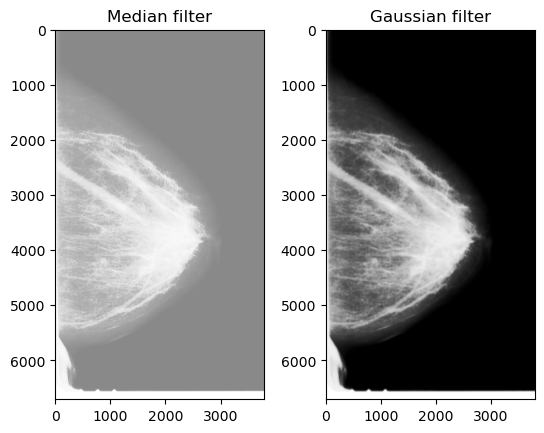

In [51]:
# smooth...
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter

image_med = medfilt(image_eq, 5)
image_gaussian = gaussian_filter(image_eq, sigma=9)

plt.subplots(1, 2)

plt.subplot(121)
plt.title("Median filter")
plt.imshow(image_med, plt.cm.gray)

plt.subplot(122)
plt.title("Gaussian filter")
plt.imshow(image_gaussian, plt.cm.gray)

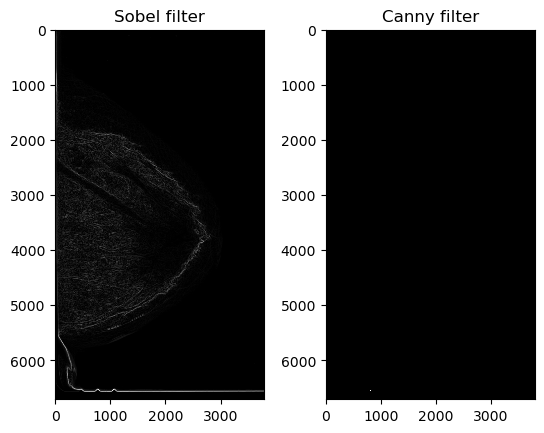

In [48]:
# get edges with Sobel
from skimage.feature import canny
from skimage.filters import sobel

sobel = sobel(image_gaussian)
canny = canny(image_gaussian, sigma=3)

plt.subplots(1, 2)

plt.subplot(121)
plt.imshow(sobel, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Sobel filter')

plt.subplot(122)
plt.imshow(canny, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Canny filter')
plt.show()

Text(0.5, 1.0, 'Binary segmentation')

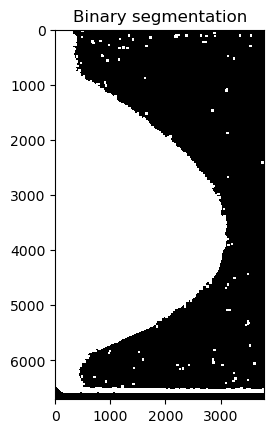

In [49]:
# initial segmentation
from scipy import ndimage as ndi

segmentation = ndi.binary_fill_holes(sobel)

plt.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Binary segmentation')

Text(0.5, 1.0, 'Cleaned up segmentation')

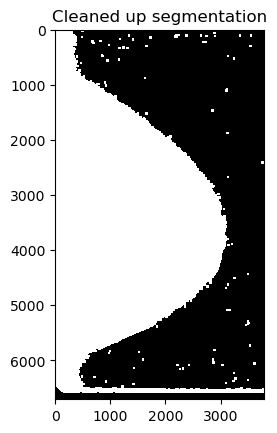

In [50]:
# clean up
from skimage import morphology

segmentation_cleaned = morphology.remove_small_objects(segmentation, 21)

plt.imshow(segmentation_cleaned, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Cleaned up segmentation')